In [281]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import re
from nltk.tokenize import sent_tokenize,word_tokenize
#import nltk
#nltk.download("punkt")
%matplotlib inline
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem.isri import ISRIStemmer  
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier 
import pickle
from flask import Flask
import itertools 
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn.svm import SVC, NuSVC

In [282]:
fake_news= pd.read_csv("f:/mervat/data science/nlp/final project/fake.csv")
fake_news.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [283]:
true_news= pd.read_csv("f:/mervat/data science/nlp/final project/True.csv")
true_news.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [284]:
true_news.shape , fake_news.shape

((21417, 4), (23481, 4))

In [285]:
true_news=true_news.iloc[:4000,:]
fake_news=fake_news.iloc[:4000,:]

In [286]:
print(f"{true_news.info()}{fake_news.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
title      4000 non-null object
text       4000 non-null object
subject    4000 non-null object
date       4000 non-null object
dtypes: object(4)
memory usage: 125.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
title      4000 non-null object
text       4000 non-null object
subject    4000 non-null object
date       4000 non-null object
dtypes: object(4)
memory usage: 125.1+ KB
NoneNone


In [287]:
fake_news["label"]=0
true_news["label"]=1

In [288]:
true_news.text.values[1][0:250]

'WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to app'

In [289]:
fake_news.text.values[500][0:250]

'In the middle of a Twitter tantrum directed toward Mitch McConnell, James Clapper, Democrats and the  fake news,  Donald Trump retweeted a bit of light hearted boasting in the form of a meme that shows Trump eclipsing President Obama.In the meme, Tru'

In [290]:
df=pd.concat([true_news,fake_news])
df.head(2)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1


# removing unwanted sentences & links,users names,hashtags in fake news 
turning the words to lowercase ,removing special char, digits,tokenziation, stopwords,lemmaitization 

In [291]:
def clean_text(text):
    text=re.sub(r"([A-Z][a-z]+(?: [A-Z][a-z]\.)? [A-Z][a-z]+)","",text)#remove names
    text=re.sub(r"\bU.S*\b","",text)
    text =text.lower()
    text=re.sub(r'\bone\b\s+|\btwo\b\s+|',"",text)
    text=re.sub(r'\W*\b\w{1}\b', "", text)
    text=re.sub(r'\W*\b\w{2}\b', "", text)
    text=re.sub(r"\s+[a-zA-Z]\s+", "", text)
    text =re.sub(r"@[a-z]+|\(@.*?\)|pic\S+|http\S+", '', text) #links,users names
    text =re.sub(r"\bfeatured.*\b|\bphoto by.*\b|\bimage credit.*\b|\#[\w]+|\bphoto by.*\b|\bimage: twitter.*\b|\bfeatured images.*\b",
                  '', text)#unwanted senteces 
    text = re.sub("^(.*?)-", '', text) #sources in true news like routers 
    text=re.sub(r"[?|$|&|*|%|@|(|)|~|!|,|.|/|\|;|:|\x07|“|-|]","" ,text)#i'm adding the char manually to keep apostrogh for stopwords
    text=re.sub(r"\d[0-9]?", "",text) #digits

    return text

In [292]:
def stop_words(text):
    new_file=open ("f:/mervat/data science/nlp/stopwords_en.txt","r")#,encoding="utf-8")
    stop_words=new_file.read().split("\n")
    needed_words=[]
    words=word_tokenize(text)
    for w in words:
        if w not in (stop_words):
            needed_words.append(w)
    filtered_sent= " ".join(needed_words)        
    return filtered_sent        

In [293]:
stop_words("december ,i, know, obama, people ,how, can, i, feel, this, shit ")

', , know , , , , , , feel , , shit'

In [294]:
def tokenization(text):
    cleaned=[re.sub("[^\w]+"," ",text).replace("  "," ").strip()]
    words_tokenization = "".join(cleaned).split(" ")
    return words_tokenization

In [295]:
tokenization("hfhhdnsnsjs,sjdj")

['hfhhdnsnsjs', 'sjdj']

In [296]:
import pattern
from pattern.en import lemma, lexeme

def lemtization(text):
    lemtization =[lemma(wd) for wd in text]
    words_after_lem=" ".join(lemtization).split(" ")
    return words_after_lem

In [297]:
lemtization(['cars',"drove"])

['car', 'drive']

In [298]:
def prepare_data(news):
    sentences=[]
    for index, r in news.iterrows():
        text = clean_text(r["text"])
        text2=stop_words(text)
        text3 =tokenization(text2)
        text4=lemtization(text3)
        if r["label"] == 1:
            sentences.append([text4,"true"])
        else:
            sentences.append([text4,"fake"])
    news_data=pd.DataFrame(sentences,columns=["text","label"]) 
#     news_data=df_sentences.loc[news_data.index.drop_duplicates()]
    return news_data   

In [299]:
data_after_pre=prepare_data(df)

In [300]:
data_after_pre.head(3)

,text,label
0,"[head, conservative, republican, faction, cong...",true
1,"[transgender, allow, enlist, military, start, ...",true
2,"[special, counsel, investigation, link, russia...",true


In [301]:
data_after_pre.text.values[1][250]

'take'

In [302]:
data_after_pre.text.values[5000][-400:-1]

['qualify',
 'care',
 'ordinary',
 'ironically',
 'country',
 'report',
 'confidence',
 'israel',
 'guess',
 'russia',
 'fact',
 'russia',
 'increase',
 'thank',
 'presidency',
 'certainly',
 'raise',
 'su',
 'check']

In [303]:
data_after_pre['length'] = data_after_pre['text'].apply(len)
data_after_pre.head(5)

,text,label,length
0,"[head, conservative, republican, faction, cong...",true,357
1,"[transgender, allow, enlist, military, start, ...",true,288
2,"[special, counsel, investigation, link, russia...",true,198
3,"[campaign, adviser, tell, australian, diplomat...",true,170
4,"[call, charge, ship, package, amazon, amzn, an...",true,371


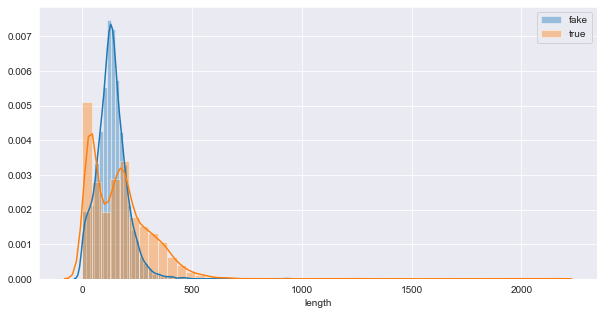

In [304]:
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")
sns.distplot(data_after_pre[data_after_pre["label"]=="fake"]["length"],label="fake");
sns.distplot(data_after_pre[data_after_pre["label"]=="true"]["length"],label="true");
plt.legend();
plt.show()

In [305]:
#word_cloud
data_fake  = data_after_pre[data_after_pre['label'] == "fake"].copy()
data_true = data_after_pre[data_after_pre['label'] == "true"].copy()

In [306]:
# data_fake

In [307]:
from wordcloud import WordCloud,STOPWORDS

In [308]:
# fake_text=data_fake.text
# fake_text

In [309]:
# test=["dossier","change"]

In [310]:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data_fake["text"].values[20])

In [311]:
words_data_fake = data_fake['text'].tolist()
words_data_true = data_true['text'].tolist()

In [312]:
words_data_fake[0:1]

[['year', 'old', 'men', 'change', 'olderphoto']]

In [313]:
list_fake_words = []
for sublist in words_data_fake:
    for item in sublist:
        list_fake_words.append(item)

In [314]:
list_true_words = []
for sublist in words_data_true:
    for item in sublist:
        list_true_words.append(item)

In [315]:
##frequancy 
vocab_occur1=nltk.FreqDist(list_fake_words)
vocab_occur1

FreqDist({'get': 3630, 'make': 3505, 'say': 3024, 'go': 2968, 'know': 2750, 'take': 2535, 'think': 2239, 'republican': 2078, 'call': 2031, 'want': 2019, ...})

In [322]:
vocab_occur1.most_common(10)

[('get', 3630),
 ('make', 3505),
 ('say', 3024),
 ('go', 2968),
 ('know', 2750),
 ('take', 2535),
 ('think', 2239),
 ('republican', 2078),
 ('call', 2031),
 ('want', 2019)]

In [317]:
vocab_occur2=nltk.FreqDist(list_true_words)
vocab_occur2

FreqDist({'tax': 5014, 'republican': 4957, 'state': 3471, 'bill': 3234, 'make': 2967, 'tell': 2868, 'official': 2810, 'can': 2741, 'administration': 2672, 'say': 2580, ...})

In [323]:
vocab_occur2.most_common(10)

[('tax', 5014),
 ('republican', 4957),
 ('state', 3471),
 ('bill', 3234),
 ('make', 2967),
 ('tell', 2868),
 ('official', 2810),
 ('can', 2741),
 ('administration', 2672),
 ('say', 2580)]

In [319]:
str_list_fake=str(list_fake_words)
str_list_true=str(list_true_words)

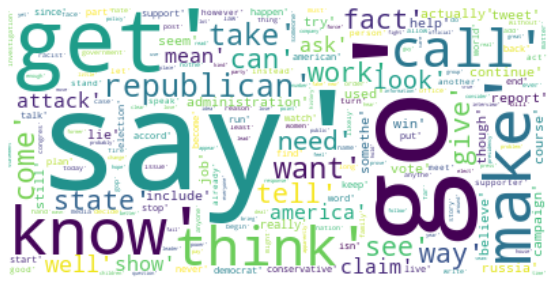

In [320]:
##wordcloud fake_news vocab
# stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color="white").generate(str_list_fake)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

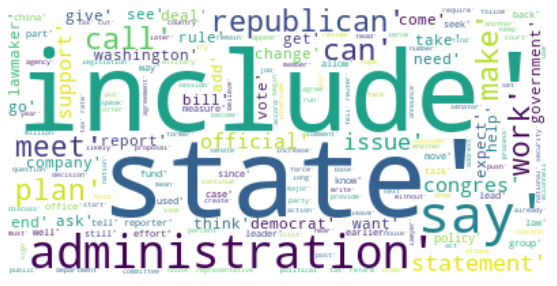

In [321]:
wordcloud = WordCloud(background_color="white").generate(str_list_true)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()